In [ ]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import proportion

In [ ]:
data = pd.read_excel('AB_Test_Results.xlsx')

In [ ]:
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
data.shape

(10000, 3)

In [ ]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [ ]:
data[data['REVENUE']>0] #срез по строкам где выручка больше 0

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


Проведем срез по каждой выборке отдельно 

In [ ]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


In [ ]:
data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


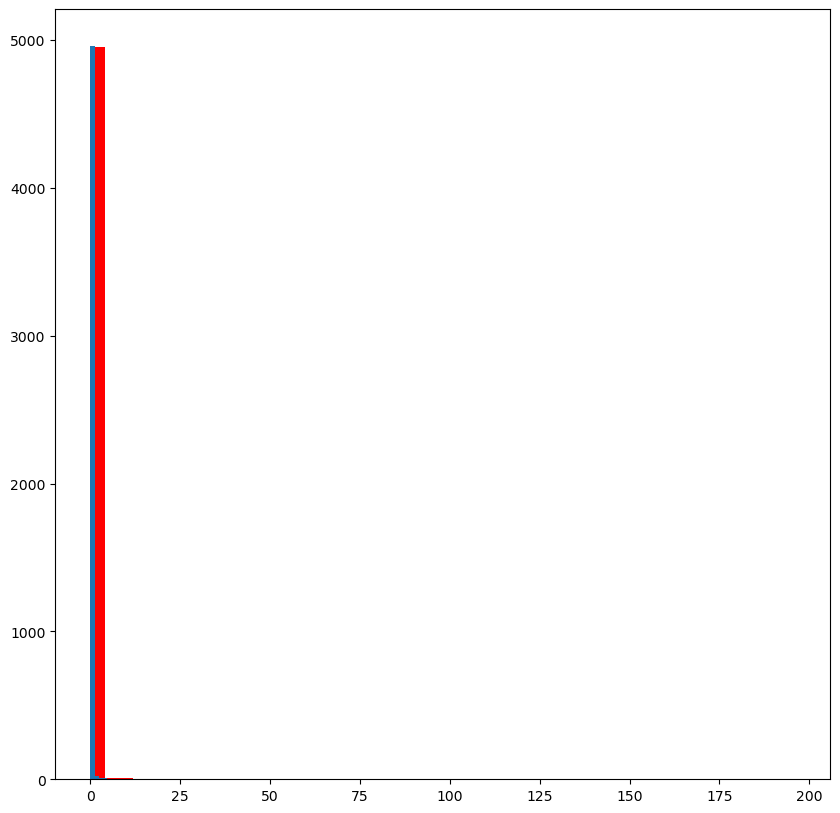

In [ ]:
plt.figure(figsize=(10, 10))
control_visit_all = data['REVENUE'][data['VARIANT_NAME']=='control']
test_visit_all = data['REVENUE'][data['VARIANT_NAME']=='variant']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all, bins=50)

plt.show()  #посмотрим график распределения
     

Видим что распределение не нормальное, но для того чтобы себя перепроверить себя запустим тест на нормальность распределения.

In [ ]:
#  тест Колмогорова-Смирнова
from scipy.stats import kstest
print(kstest(control_visit_all, 'norm'))
print(kstest(test_visit_all, 'norm'))

KstestResult(statistic=0.5, pvalue=0.0)
KstestResult(statistic=0.5, pvalue=0.0)


Видим что pvalue < 0.05, что позводялет нам сделать вывод что данные распределены не нормально.

In [ ]:
v = data.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique}) 
    #Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

In [ ]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [ ]:
control = data.query('VARIANT_NAME == "control"')

test = data.query('VARIANT_NAME == "variant"')

In [ ]:
len(control)

4984

In [ ]:
len(test)

5016

In [ ]:
from scipy.stats import shapiro

In [ ]:
#Запустим тест Шапиро провери нормальность распределения. 
alpha = 0.05

st = shapiro(data.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



Еще раз убедились, что распределение не нормальное

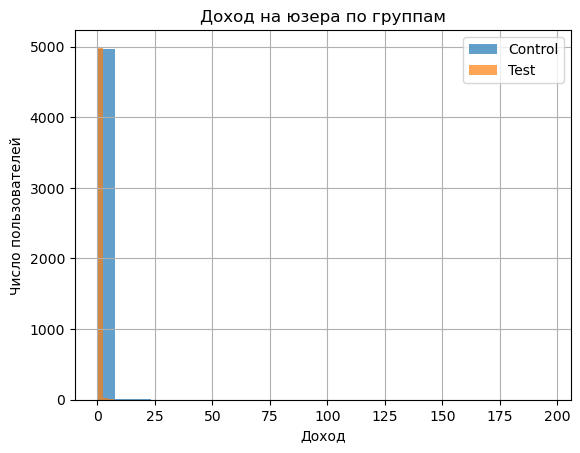

In [ ]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

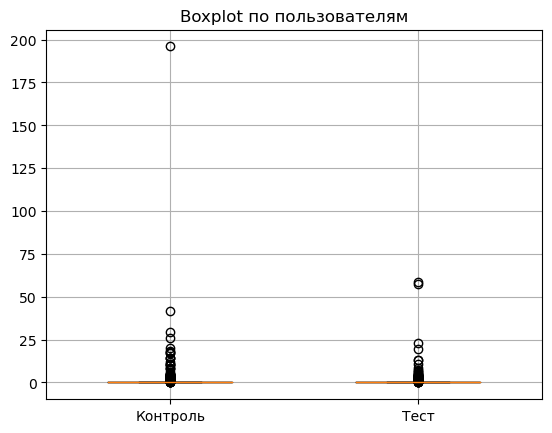

In [ ]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [ ]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.268403803110966, pvalue=0.20469713432410777)

pvalue > 0.05 , нет статистической значимости

In [ ]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [ ]:
len(control.REVENUE.values)

4984

In [ ]:
len(test.REVENUE.values)

5016

In [ ]:
n =  len(control.REVENUE.values)

In [ ]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [ ]:
effect =float((T_mean-C_mean)/ S) 

In [ ]:
from statsmodels.stats.power import TTestIndPower

In [ ]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result

0.24502831099016653

In [1]:
#Выводы: нет статистической значимой разности по нашей ключевой метрике. 
#Также сам тетс вызывает вопросы т.к юзера попали в две тестовые группы. 
#Можно сделать выводы что тест был поставлен не корректно, поэтому результаты теста нельзя использовать.    

SyntaxError: invalid syntax (1268770000.py, line 2)